In [1]:
import sys, os
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def load_dcm(name):
    """
    loads the dcm file
    :param path:    name of the image

    :return:        dcm data
    """

    cwd = os.getcwd()
    rootFolder = cwd[:cwd.rfind("/", 0, cwd.rfind("/"))]
    path = rootFolder+"/res/images/"+name

    try:
        return pydicom.dcmread(path)
    except FileNotFoundError:
        print("place the image in the res/images folder, and make sure that this script is running from src/notebooks folder.")

In [3]:
def load_img(name, gray_scale = False):
    """
    loads the image file
    :param path:    name of the image

    :return:        image
    """
    
    cwd = os.getcwd()
    rootFolder = cwd[:cwd.rfind("/", 0, cwd.rfind("/"))]
    path = rootFolder+"/res/images/"+name
    
    try:
        if gray_scale:
            return cv2.imread(path, 0)
        return cv2.imread(path)
    except FileNotFoundError:
        print("place the image in the res/images folder, and make sure that this script is running from src/notebooks folder.")
       

In [43]:
def high_pass_filter(img, sigma):
    """
    applies gaussian high pass filter in frequency domain
    
    :param img:     the image
    :param sigma:   filter amount

    :return:        filtered image
    """ 

    rows = img.shape[0]
    cols = img.shape[1]

    M = 2*rows + 1
    N = 2*cols + 1
    (X, Y) = np.meshgrid(np.linspace(0, N-1, N), np.linspace(0, M-1, M))
    centerX = np.ceil(N/2)
    centerY = np.ceil(M/2)

    # gaussian low pass filter
    gaussianNumerator = (X - centerX)**2 + (Y - centerY)**2
    H = np.exp(-gaussianNumerator/(2*sigma*sigma))

    # high pass filter
    H = 1 - H
    alpha = 0.5
    beta = 1.5
    Hemphasis = alpha + beta*H # high frequency emphasis filter

    # shift zero-frequency component to center (useful for visualizing a 
    # Fourier transform with the zero-frequency component in the middle of the spectrum.)
    # (in other words, shift the filter to the center)
    Hemphasis = np.fft.fftshift(Hemphasis)

    # applying filter
    If = np.fft.fft2(img, (M, N))
    Iout = np.real(np.fft.ifft2(If * Hemphasis, (M, N)))

    # trimming extra padding
    Iout = Iout[0:rows, 0:cols]
    
    return Iout

In [5]:
def homomorphic_filter(img, resize=False):
    """
    applies homomorphic filtering on image.

    :param img:     the image (from dcm file data)
    :param resize:  defaults to False. otherwise a tuple consisting of new 
                    image size

    :return:        filtered image
    """

    if resize:
        # img = skimage.transform.resize(img, resize, anti_aliasing=True)
        img = cv2.resize(img, resize)
    
    img = im2double(img) 
    imgLog = np.log1p(img)
    Iout = high_pass_filter(imgLog, 10)
    return np.expm1(Iout)

In [6]:
def imtophat(img, se_type, se_size):
    """
    applies tophat transform on image.

    :param img:     the image
    :param se_type: the type of structuring element(from opencv)
    :param se_size: the size of the structuring element

    :return:        the transformed image
    """

    se = cv2.getStructuringElement(se_type, se_size)
    return cv2.morphologyEx(img, cv2.MORPH_TOPHAT, se)

In [7]:
def imbothat(img, se_type, se_size):
    """
    applies tophat transform on image.

    :param img:     the image
    :param se_type: the type of structuring element(from opencv)
    :param se_size: the size of the structuring element

    :return:        the transformed image
    """

    se = cv2.getStructuringElement(se_type, se_size)
    return cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, se)


In [39]:
def adapthisteq(img, clip_limit = 0.02, tile_grid_size = (8, 8)):
    """
    performs Constrast Limiting Adaptive Histogram Equalization on image.

    :param img:             the input image
    :param clip_limit:      the clip limit for CLAHE
    :param tile_grid_size:  the tile size for CLAHE

    :return:                the processed image
    """

    if img.dtype == np.dtype("float"):
        img = np.interp(img, (img.min(), img.max()), (0, 255)).astype('uint8')

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

In [9]:
def save_image(img, name, cm=False):
    """
    saves the image to res/images/output

    :param img:     the image to be saved
    :param name:    the name of the image
    """

    cwd = os.getcwd()
    rootFolder = cwd[:cwd.rfind("/", 0, cwd.rfind("/"))]
    path = rootFolder+"/res/images/output/"+name

    if cm == True:
        plt.imsave(path, img, cmap="bone")
    elif cm != True and cm != False:
        plt.imsave(path, img, cmap=cm) 
    else:
        cv2.imwrite(path, img*255)


In [10]:
def im2double(img):
    """
    converts image to double values ranging from 0 to 1. if image is already of float type,
    returns the image as is.

    :param img: the image to convert.

    :return:    the converted image.
    """

    if img.dtype == np.dtype("float"):
        return img

    info = np.iinfo(img.dtype)
    return img.astype(np.float)/info.max

In [27]:
def view(images, titles=[], figsize=(8, 6)):
    if type(images) != list:
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(images, cmap="gray")
        if titles != []:
            ax.set_title(titles)
        return
    
    grid_size = int(np.ceil(np.sqrt(len(images))))
    fig, ax = plt.subplots(grid_size, grid_size, figsize=figsize)
    i = 0
    j = 0
    for image, title in zip(images, titles):
        ax[i, j].imshow(image, cmap="gray")
        ax[i, j].set_title(title)
        j+=1
        if(j==grid_size):
            j=0
            i+=1

In [ ]:
def apply_filters(img, figsize=(16, 14), resize=False, clip_limit=0.02, tile_grid_size=(8, 8), image_name=None):
    print("applying homomorphic filtering...")
    Ihmf = homomorphic_filter(img, resize=resize)
    print("applying tophat transform...")
    tophat = imtophat(Ihmf, cv2.MORPH_ELLIPSE, (29, 29))
    print("applying bothat transform...")
    bothat = imbothat(Ihmf, cv2.MORPH_ELLIPSE, (29, 29))
    print("applying CLAHE...")
    processedImage = adapthisteq((Ihmf + tophat) - bothat, clip_limit=clip_limit, tile_grid_size=(8, 8))
    print("done.")
    
#     save_image(Ihmf, image_name+"-HomomorphicFilter.jpg", cm="gray")
#     save_image(tophat, image_name+"-tophat.jpg", cm="gray")
#     save_image(bothat, image_name+"-bothat.jpg", cm="gray")
#     save_image(processedImage, image_name+"-final.jpg", cm="gray")

    view([Ihmf, tophat, bothat, processedImage], ["homomorphic filtering", "tophat", "bothat", "CLAHE"], figsize)

applying homomorphic filtering...
applying tophat transform...
applying bothat transform...
applying CLAHE...
done.


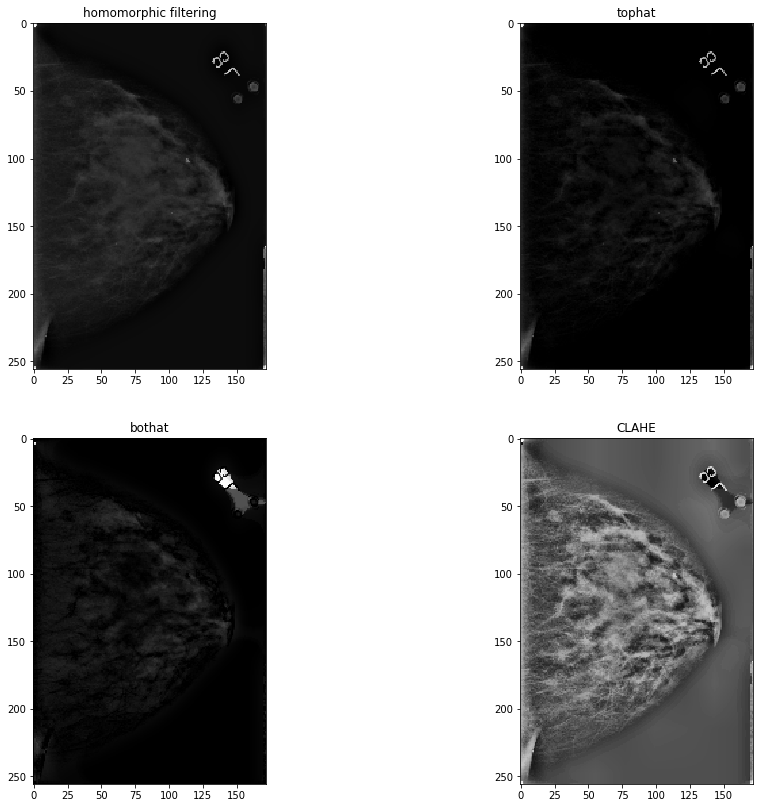

In [56]:
dcm_data = load_dcm("000000.dcm")
apply_filters(dcm_data.pixel_array, resize=(172, 256), clip_limit=4, image_name="000000Small")

applying homomorphic filtering...
applying tophat transform...
applying bothat transform...
applying CLAHE...
done.


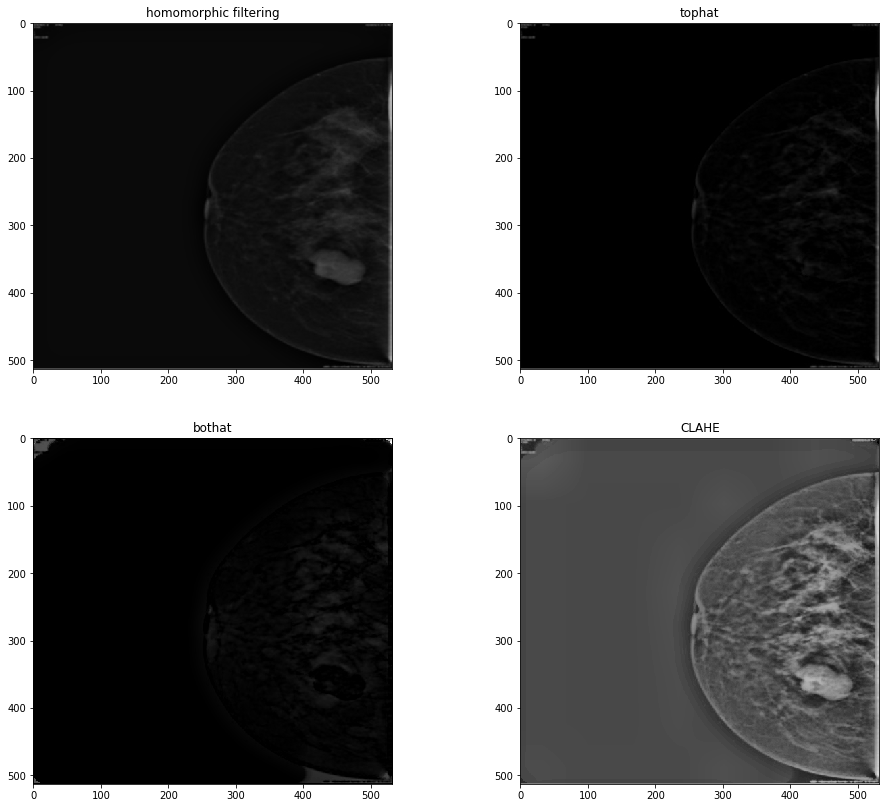

In [51]:
img = load_img("test.jpg", gray_scale=True)
apply_filters(img, clip_limit=4, image_name="test")